In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import cv2
from load_dataset import load_standardised_dataset
from image_standardisation import restore_standardised_image

In [2]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras import layers, losses, metrics
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

2023-01-23 17:11:52.913767: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-23 17:11:54.293950: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/garbarkozaurus/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-01-23 17:11:54.293993: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-23 17:11:56.183415: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7

In [3]:
np.random.seed(256)
path_to_dataset = Path("../SIDD_Small_sliced/Data/")
TRAIN_PAIRS_TO_LOAD = 1000
TEST_PAIRS_TO_LOAD = TRAIN_PAIRS_TO_LOAD//8
VAL_PAIRS_TO_LOAD = TRAIN_PAIRS_TO_LOAD//8
train_x, train_y, test_x, test_y, val_x, val_y = load_standardised_dataset(str(path_to_dataset), TRAIN_PAIRS_TO_LOAD, TEST_PAIRS_TO_LOAD, VAL_PAIRS_TO_LOAD)

In [4]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(256, 256, 3)),
      layers.Conv2D(16, (3, 3), activation='leaky_relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='leaky_relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='leaky_relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='leaky_relu', padding='same'),
      layers.Conv2D(3, kernel_size=(3, 3), activation="tanh", padding='same')
      ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [5]:
autoencoder = Denoise()
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics=["kullback_leibler_divergence", "MAE"])

2023-01-23 17:12:07.905187: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-23 17:12:07.905308: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/garbarkozaurus/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-01-23 17:12:07.905367: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/garbarkozaurus/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-01-23 17:12:07.905417: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loade

In [6]:
early = EarlyStopping(patience=3, restore_best_weights=True)
reduce = ReduceLROnPlateau(monitor='loss', patience=2)

In [7]:
history = autoencoder.fit(train_x, train_y,
                epochs=10,
                shuffle=True,
                validation_data=(val_x, val_y),
                callbacks=[early, reduce])

2023-01-23 17:12:08.524770: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 786432000 exceeds 10% of free system memory.


Epoch 1/10


2023-01-23 17:12:08.712280: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 786432000 exceeds 10% of free system memory.


32/32 [==============================] - 34s 1s/step - loss: 0.0899 - kullback_leibler_divergence: 1.7589 - MAE: 0.2441 - val_loss: 0.0308 - val_kullback_leibler_divergence: 0.8659 - val_MAE: 0.1336 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - 31s 958ms/step - loss: 0.0161 - kullback_leibler_divergence: 0.2813 - MAE: 0.0896 - val_loss: 0.0106 - val_kullback_leibler_divergence: 0.1376 - val_MAE: 0.0705 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - 31s 966ms/step - loss: 0.0102 - kullback_leibler_divergence: 0.1589 - MAE: 0.0677 - val_loss: 0.0095 - val_kullback_leibler_divergence: 0.0971 - val_MAE: 0.0645 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - 34s 1s/step - loss: 0.0094 - kullback_leibler_divergence: 0.1226 - MAE: 0.0637 - val_loss: 0.0090 - val_kullback_leibler_divergence: 0.1018 - val_MAE: 0.0620 - lr: 0.0010
Epoch 5/10
32/32 [==============================] - 33s 1s/step - loss: 0.0089 - kullback_leibler_divergence: 0.1

In [8]:
autoencoder.encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 8)         1160      
                                                                 
Total params: 1,608
Trainable params: 1,608
Non-trainable params: 0
_________________________________________________________________


In [17]:
autoencoder.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (None, 128, 128, 8)      584       
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 256, 256, 16)     1168      
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 3)       435       
                                                                 
Total params: 2,187
Trainable params: 2,187
Non-trainable params: 0
_________________________________________________________________


In [9]:
encoded_imgs = autoencoder.encoder(test_x).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

2023-01-23 17:17:42.357320: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 524288000 exceeds 10% of free system memory.
2023-01-23 17:17:42.758241: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 524288000 exceeds 10% of free system memory.
2023-01-23 17:17:42.863679: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 524288000 exceeds 10% of free system memory.


In [10]:
rgb_decoded_imgs = np.array([restore_standardised_image(img) for img in decoded_imgs])

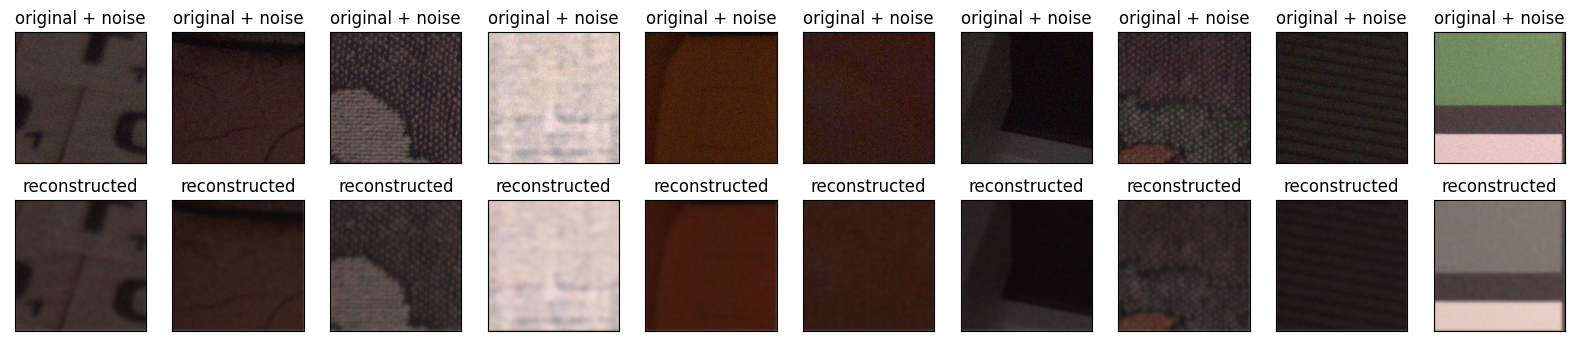

In [11]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(restore_standardised_image(test_x[i])))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(rgb_decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

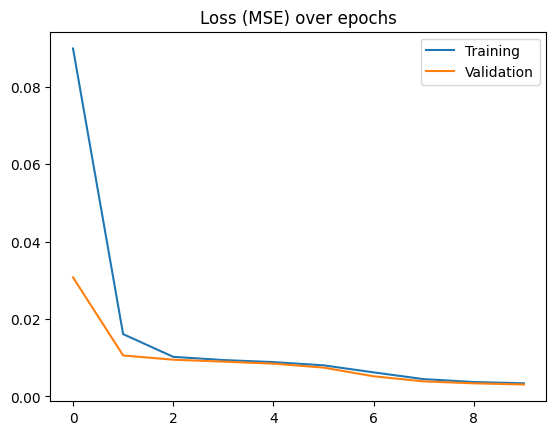

In [34]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["Training", "Validation"])
plt.title("Loss (MSE) over epochs")
plt.show()

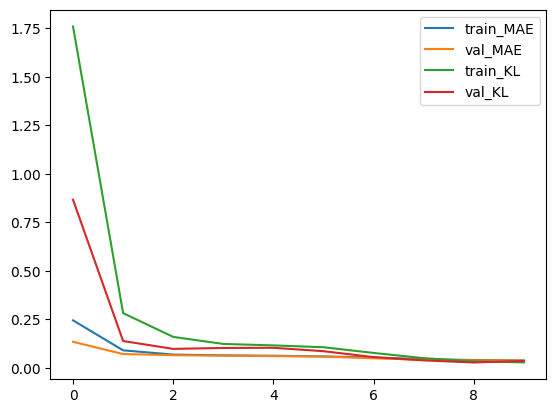

In [36]:
plt.plot(history.history["MAE"])
plt.plot(history.history["val_MAE"])
plt.plot(history.history["kullback_leibler_divergence"])
plt.plot(history.history["val_kullback_leibler_divergence"])
plt.legend(["train_MAE", "val_MAE", "train_KL", "val_KL"])
plt.show()


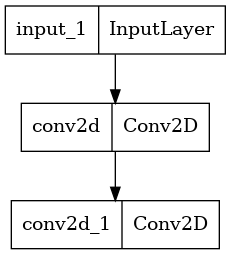

In [16]:
plot_model(autoencoder.encoder)

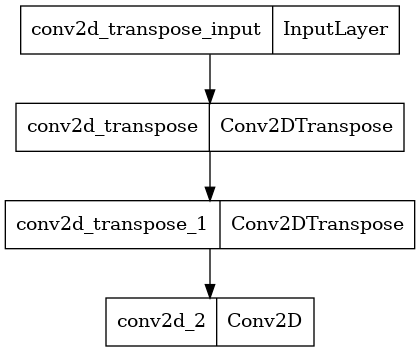

In [15]:
plot_model(autoencoder.decoder)

In [25]:
autoencoder.encoder.save("basic_autoencoder_encoder.h5")
autoencoder.decoder.save("basic_autoencoder_decoder.h5")

In [33]:
import os
# Get file size in bytes for a given model
encoder_bytes = os.stat('basic_autoencoder_encoder.h5').st_size
decoder_bytes = os.stat('basic_autoencoder_decoder.h5').st_size
print(f"Encoder size in memory: {encoder_bytes} B = {encoder_bytes/1024} KiB = {encoder_bytes/1024**2} MiB = {encoder_bytes/1024**3} GiB")
print(f"Decoder size in memory: {decoder_bytes} B = {decoder_bytes/1024} KiB = {decoder_bytes/1024**2} MiB = {decoder_bytes/1024**3} GiB")

Encoder size in memory: 19752 B = 19.2890625 KiB = 0.01883697509765625 MiB = 1.839548349380493e-05 GiB
Decoder size in memory: 25040 B = 24.453125 KiB = 0.0238800048828125 MiB = 2.3320317268371582e-05 GiB


---
## Testing other optimisers

Adagrad

In [40]:
autoencoder_adagrad = Denoise()
autoencoder_adagrad.compile(optimizer='adagrad', loss=losses.MeanSquaredError(), metrics=["kullback_leibler_divergence", "MAE"])

In [41]:
history_adagrad = autoencoder_adagrad.fit(train_x, train_y,
                epochs=10,
                shuffle=True,
                validation_data=(val_x, val_y),
                callbacks=[early, reduce])

Epoch 1/10
32/32 [==============================] - 48s 1s/step - loss: 0.1573 - kullback_leibler_divergence: 1.6565 - MAE: 0.3496 - val_loss: 0.1545 - val_kullback_leibler_divergence: 2.0668 - val_MAE: 0.3481 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - 35s 1s/step - loss: 0.1506 - kullback_leibler_divergence: 1.9696 - MAE: 0.3412 - val_loss: 0.1493 - val_kullback_leibler_divergence: 2.2606 - val_MAE: 0.3416 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - 32s 986ms/step - loss: 0.1459 - kullback_leibler_divergence: 2.1129 - MAE: 0.3354 - val_loss: 0.1453 - val_kullback_leibler_divergence: 2.3664 - val_MAE: 0.3366 - lr: 0.0010
Epoch 4/10
13/32 [===========>..................] - ETA: 19s - loss: 0.1458 - kullback_leibler_divergence: 2.2613 - MAE: 0.3344

In [ ]:
plt.plot(history_adagrad.history["loss"])
plt.plot(history_adagrad.history["val_loss"])
plt.legend(["Training", "Validation"])
plt.title("Adagrad - Loss (MSE) over epochs")
plt.show()

In [ ]:
plt.plot(history_adagrad.history["MAE"])
plt.plot(history_adagrad.history["val_MAE"])
plt.plot(history_adagrad.history["kullback_leibler_divergence"])
plt.plot(history_adagrad.history["val_kullback_leibler_divergence"])
plt.legend(["train_MAE", "val_MAE", "train_KL", "val_KL"])
plt.title("Adagrad - metrics")
plt.show()

RMSprop

In [ ]:
autoencoder_RMSprop = Denoise()
autoencoder_adagrad.compile(optimizer='RMSprop', loss=losses.MeanSquaredError(), metrics=["kullback_leibler_divergence", "MAE"])

In [ ]:
history_RMSprop = autoencoder_RMSprop.fit(train_x, train_y,
                epochs=10,
                shuffle=True,
                validation_data=(val_x, val_y),
                callbacks=[early, reduce])

In [ ]:
plt.plot(history_RMSprop.history["loss"])
plt.plot(history_RMSprop.history["val_loss"])
plt.legend(["Training", "Validation"])
plt.title("Adagrad - Loss (MSE) over epochs")
plt.show()

In [ ]:
plt.plot(history_RMSprop.history["MAE"])
plt.plot(history_RMSprop.history["val_MAE"])
plt.plot(history_RMSprop.history["kullback_leibler_divergence"])
plt.plot(history_RMSprop.history["val_kullback_leibler_divergence"])
plt.legend(["train_MAE", "val_MAE", "train_KL", "val_KL"])
plt.title("Adagrad - metrics")
plt.show()

SGD

In [ ]:
autoencoder_SGD = Denoise()
autoencoder_SGD.compile(optimizer='SGD', loss=losses.MeanSquaredError(), metrics=["kullback_leibler_divergence", "MAE"])

In [ ]:
history_SGD = autoencoder_SGD.fit(train_x, train_y,
                epochs=10,
                shuffle=True,
                validation_data=(val_x, val_y),
                callbacks=[early, reduce])

In [ ]:
plt.plot(history_SGD.history["loss"])
plt.plot(history_SGD.history["val_loss"])
plt.legend(["Training", "Validation"])
plt.title("Adagrad - Loss (MSE) over epochs")
plt.show()

In [ ]:
plt.plot(history_SGD.history["MAE"])
plt.plot(history_SGD.history["val_MAE"])
plt.plot(history_SGD.history["kullback_leibler_divergence"])
plt.plot(history_SGD.history["val_kullback_leibler_divergence"])
plt.legend(["train_MAE", "val_MAE", "train_KL", "val_KL"])
plt.title("Adagrad - metrics")
plt.show()